# Algorithms for efficient entropy conversion

By Calum Grant, June 2025

This page is to reproduce the results of the accompanying paper.

The code is in the accompanying [entropy.py](entropy.py) file. We'll import it as follows:

In [35]:
from entropy import *

## Basic entropy operations

The 4 basic operations are provided by `multiply()`, `divide()`, `downsample()` and `upsample()` functions.

In [36]:
multiply(1,6,4,5)

(25, 30)

In [37]:
divide(25,30,6)

(1, 6, 4, 5)

In [38]:
downsample(10,36,3)

(7, 33, False)

In [39]:
upsample(7, 33, 36, False)

(10, 36)

## Distributions

The `entropy` module also defines the distributions `U` and `B`. We can construct `U` objects manually as follows:

In [40]:
U(4,6)

U(6)

The default `U` object has size 1, which means it has no entropy.

In [41]:
U()

U(1)

We can measure the stored entropy using the `entropy()` method:

In [42]:
U().entropy()

0.0

In [43]:
U(1,6).entropy()

2.584962500721156

Whenever you read or consume the entropy, the original entropy becomes empty (`U(1)`). This is to prevent errors reusing the same entropy.

In [44]:
x = U(1,6)
x.entropy()
x.read()

1

Calling `read()` turned `x` into a pumpkin!

In [45]:
x


U(1)

In [46]:
x.entropy()

0.0

The basic entropy operations are implemented on `U`:

In [47]:
U(1,6).multiply(U(2,6))

U(36)

In [48]:
U(10,36).downsample(10)

(U(26), B(10/36))

In [49]:
U(9,36).downsample(10)

(U(10), B(10/36))

The entropy operations *destroy* the original entropy, to prevent errors.

In [50]:
x = U(1,6)
y = x.multiply(U(3,6))
x

U(1)

# Calculating entropy for individual integers

The functions `expected_rejection_sampling()`, `expected_fast_dice_roller()` and `worst_case_eec()` calculate 
the expected entropy consumption for each integer generated. For example:

In [51]:
expected_rejection_sampling(3), expected_fast_dice_roller(3), worst_case_eec(3)

(2.6666666666666665, 2.6666259765625, 1.5849625300044479)

Interestingly, `worst_case_convert` actually gives a entropy slightly higher for powers of 2, but this is correct.

In [52]:
expected_rejection_sampling(4), expected_fast_dice_roller(4), worst_case_eec(4)

(2.0, 2, 2.0000000431077543)

Let's calculate the entropy efficiency generating the first 100 integers.

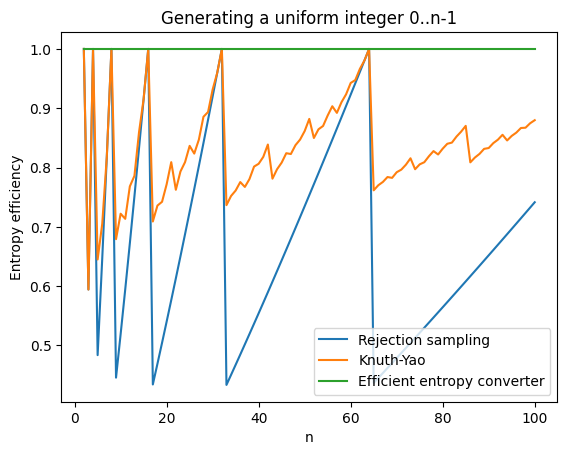

In [53]:
numbers = range(2,101)
rs_efficiency = [math.log2(n)/expected_rejection_sampling(n) for n in numbers]
fdr_efficiency = [math.log2(n)/expected_fast_dice_roller(n) for n in numbers]
eec_efficiency = [math.log2(n)/worst_case_eec(n) for n in numbers]

import matplotlib.pyplot as plt
plt.title('Generating a uniform integer 0..n-1')
plt.xlabel('n')
plt.ylabel('Entropy efficiency')
plt.plot(numbers, rs_efficiency, label='Rejection sampling')
plt.plot(numbers, fdr_efficiency, label='Knuth-Yao')
plt.plot(numbers, eec_efficiency, label='Efficient entropy converter')
plt.legend()
plt.show()

## Calculating entropy of card shuffling

Entropy of card shuffling just combines the entropy needed for a Fisher-Yates shuffling algorithm.

In [54]:
def expected_card_shuffling(n:int, expected) -> float:
    output = 0
    input = 0
    for i in range(2,n+1):
        output += math.log2(i)
        input += expected(i)   
    return output, input, output/input

Test it on a deck of 52 cards

In [55]:
expected_card_shuffling(52, expected_rejection_sampling)

(225.58100312370277, 355.90835089243757, 0.6338176740109078)

In [56]:
expected_card_shuffling(52, expected_fast_dice_roller)

(225.58100312370277, 277.8389933995495, 0.811912684981922)

In [57]:
expected_card_shuffling(52, worst_case_eec)

(225.58100312370277, 225.581020089913, 0.9999999247888398)

Now just draw a graph of decks size 2 to 100

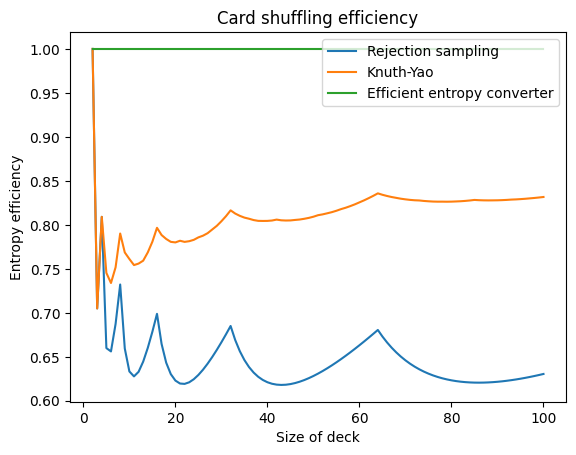

In [58]:
numbers = range(2,101)
rs_efficiency = [expected_card_shuffling(n, expected_rejection_sampling)[2] for n in numbers]
fdr_efficiency = [expected_card_shuffling(n, expected_fast_dice_roller)[2] for n in numbers]
eec_efficiency = [expected_card_shuffling(n, worst_case_eec)[2] for n in numbers]

plt.clf()
plt.title('Card shuffling efficiency')

plt.xlabel('Size of deck')
plt.ylabel('Entropy efficiency')
plt.plot(numbers, rs_efficiency, label='Rejection sampling')
plt.plot(numbers, fdr_efficiency, label='Knuth-Yao')
plt.plot(numbers, eec_efficiency, label='Efficient entropy converter')
plt.legend(loc='upper right')
plt.show()

## Simulations

We can actually implement entropy generators based on the above algorithms to see how they perform in practice.

In [59]:
bin = BinaryEntropySource()

`MeasuringSource` wraps any entropy source and keeps track of how much entropy was delivered.

In [60]:
measured_input = MeasuringSource(bin)

In [61]:
rs = RejectionSamplingEntropySource(measured_input)
fdr = FastDiceRollerEntropySource(measured_input)
eec = EfficientEntropySource(measured_input)

Set up an entropy store based on rejection sampling and measure its outputs:

In [62]:
def measure_card_shuffle(input, output):
    input.entropy = 0
    output.entropy = 0
    shuffle(deck(), output)
    return input.entropy

measure_card_shuffle(measured_input, MeasuringSource(rs))

364.0

Note this will vary between runs.

In [63]:
measure_card_shuffle(measured_input, MeasuringSource(fdr))

277.0

Note this will vary between runs.

Finally, let's measure how much entropy the efficient entropy converter uses to shuffle a deck:

In [64]:
eec.store = U()
measure_card_shuffle(measured_input, MeasuringSource(eec)) - eec.store.entropy()

225.58100347975855

Note that this is a little better than our calculated worst-case scenario.